In [1]:
import argparse
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [17]:
input_path = "./data/raw/2021_set_n1/2021_05_02-16_44_00.csv"
df = pd.read_csv(input_path)
freq = [x for x in df.columns if "CL" in x]
data = df[freq].to_numpy()
time = 0.02 * np.arange(data.shape[0])


array([0.0000e+00, 2.0000e-02, 4.0000e-02, ..., 1.2094e+02, 1.2096e+02,
       1.2098e+02])

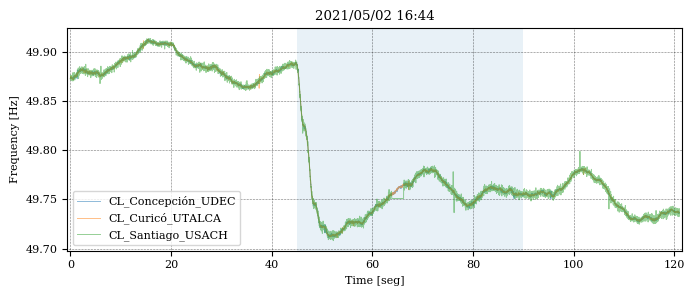

In [92]:
font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)
plt.rcParams['axes.xmargin'] = .005

fig = plt.figure(figsize=(7,3))

t0 = 45
tm = 90
plt.axvspan(t0, tm, alpha=.1)

plt.grid(color='k', linestyle='dotted', linewidth=.4)

plt.plot(time, data, alpha=.5, linewidth=.7)
plt.title("2021/05/02 16:44")
plt.xlabel("Time [seg]")
plt.ylabel("Frequency [Hz]")

plt.legend(freq)

#plt.text( 60.5, 49.815, 'Identification\nInterval', alpha=.3)

fig.tight_layout()

plt.savefig('./img/DataExample.pdf')